In [1]:
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 8,
    "lines.linewidth": 2,
    "lines.markersize": 3,
})

# print(os.getcwd())
# Load the file
df = pd.read_csv("datasets/Actual_all/actual_PV_2022-2024.csv")
# Check the first few rows
print(df.dtypes)
df.head()

datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
0,2022-01-01 00:00:00,BZN|ES,Solar,75.0
1,2022-01-01 01:00:00,BZN|ES,Solar,75.0
2,2022-01-01 02:00:00,BZN|ES,Solar,75.0
3,2022-01-01 03:00:00,BZN|ES,Solar,75.0
4,2022-01-01 04:00:00,BZN|ES,Solar,75.0


In [2]:
# Cell 2 - Modified to filter June-August data only
df = pd.read_csv("datasets/Actual_all/actual_PV_2022-2024.csv")

# Convert datetime column to proper datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Rename the generation column
df['generation'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['datetime', 'generation']].sort_values('datetime')

# Filter for June-August only (months 6, 7, 8)
df['month'] = df['datetime'].dt.month
df = df[df['month'].isin([6, 7, 8])].copy()

# Aggregate to daily data (sum of hourly values)
df['date'] = df['datetime'].dt.date
df_daily = df.groupby('date').agg({
    'generation': 'sum'  # Sum hourly MWh to get daily MWh
}).reset_index()

# Convert date back to datetime for consistency
df_daily['datetime'] = pd.to_datetime(df_daily['date'])
df = df_daily[['datetime', 'generation']].copy()

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Total records: {len(df)} days")
print(f"Frequency: Daily (aggregated from hourly)")
print(f"Months included: June, July, August only")

# Verify months
print(f"\nMonth distribution:")
print(df['datetime'].dt.month.value_counts().sort_index())

datetime      datetime64[ns]
generation           float64
dtype: object
    datetime  generation
0 2022-06-01    124812.0
1 2022-06-02    107789.0
2 2022-06-03    120057.0
3 2022-06-04    124978.0
4 2022-06-05    142973.0

Data range: 2022-06-01 00:00:00 to 2024-08-31 00:00:00
Total records: 276 days
Frequency: Daily (aggregated from hourly)
Months included: June, July, August only

Month distribution:
datetime
6    90
7    93
8    93
Name: count, dtype: int64


In [3]:
# Cell 3 (VSC-0a334ae6) - Update labels for daily data
# Data quality check and outlier detection
print("Data Quality Analysis (Daily Data):")
print("=" * 60)

# Check for missing values
missing_count = df['generation'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['generation'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['generation'].quantile(0.25)
Q3 = df['generation'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['generation'] < lower_bound) | (df['generation'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics (Daily MWh):")
print(f"  Min: {df['generation'].min():.2f} MWh")
print(f"  Max: {df['generation'].max():.2f} MWh")
print(f"  Mean: {df['generation'].mean():.2f} MWh")
print(f"  Median: {df['generation'].median():.2f} MWh")
print(f"  Std: {df['generation'].std():.2f} MWh")
print(f"  95th percentile: {df['generation'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['generation'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['generation'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['generation'] > max_reasonable, 'generation'] = max_reasonable
df_cleaned.loc[df_cleaned['generation'] < 0, 'generation'] = 0  # Remove any negative values

capped_count = (df['generation'] != df_cleaned['generation']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis (Daily Data):
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics (Daily MWh):
  Min: 52057.00 MWh
  Max: 234514.00 MWh
  Mean: 157770.92 MWh
  Median: 157510.00 MWh
  Std: 35819.39 MWh
  95th percentile: 217674.75 MWh
  99th percentile: 228079.00 MWh

Capped 0 extreme values to max: 250886.90 MWh
Data is ready for modeling


**Features created. Overall are 35 features**

In [4]:
# Cell 4 - Modified feature creation for summer months only
# Create time-based features for XGBoost - DAILY DATA (SUMMER ONLY)
def create_features(df):
    """
    Create features for DAILY solar generation forecasting - SUMMER MONTHS ONLY
    Focuses on June-August patterns
    """
    df = df.copy()
    
    # Basic time features (daily level)
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    #df['year'] = df['datetime'].dt.year
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['dayofyear'] = df['datetime'].dt.dayofyear
    df['weekofyear'] = df['datetime'].dt.isocalendar().week.astype(int)
    
    # Summer-specific features
    df['days_since_june1'] = (df['datetime'] - pd.Timestamp(str(df['datetime'].dt.year.iloc[0]) + '-06-01')).dt.days
    
    # Cyclical encoding for day of month (within summer period)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Solar declination (sun's position throughout the year)
    declination = 23.45 * np.sin(2 * np.pi * (df['dayofyear'] - 81) / 365)
    df['solar_declination'] = declination
    
    # Day length (hours of daylight)
    latitude = 45  # Europe
    hour_angle_sunrise = np.arccos(-np.tan(np.radians(latitude)) * np.tan(np.radians(declination)))
    df['day_length'] = 2 * np.degrees(hour_angle_sunrise) / 15
    df['day_length'] = df['day_length'].clip(lower=0, upper=24)
    
    # Maximum solar elevation at solar noon
    df['max_solar_elevation'] = 90 - abs(latitude - declination)
    df['max_solar_elevation'] = df['max_solar_elevation'].clip(lower=0)
    
    # Theoretical clear sky daily energy
    df['theoretical_daily_energy'] = df['day_length'] * np.sin(np.radians(df['max_solar_elevation'])) ** 1.5
    
    # Month indicators (relative to summer)
    df['is_june'] = (df['month'] == 6).astype(int)
    df['is_july'] = (df['month'] == 7).astype(int)
    df['is_august'] = (df['month'] == 8).astype(int)
    
    # Weekend/weekday
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Interaction features
    df['month_x_declination'] = df['month'] * df['solar_declination']
    df['dayofyear_x_daylength'] = df['dayofyear'] * df['day_length']
    df['month_x_day'] = df['month'] * df['day']
    
    # Higher order features
    df['day_length_sq'] = df['day_length'] ** 2
    df['max_elevation_sq'] = df['max_solar_elevation'] ** 2
    df['theoretical_energy_sq'] = df['theoretical_daily_energy'] ** 2
    
    return df

# Create features for summer data
print("Creating features for June-August daily data...")
df = create_features(df)

df_clean = df.copy()

print(f"Total data points: {len(df_clean)} days")
print(f"Features created: {len([col for col in df_clean.columns if col not in ['datetime', 'generation']])}")
print(f"\nFeature list:")
print([col for col in df_clean.columns if col not in ['datetime', 'generation']])

# Split data into train (70%), validation (20%), and test (10%)
total_rows = len(df_clean)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

train_df = df_clean.iloc[:train_size].copy()
val_df = df_clean.iloc[train_size:train_size + val_size].copy()
test_df = df_clean.iloc[train_size + val_size:].copy()

print(f"\nTraining set: {len(train_df)} days")
print(f"  Period: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"\nValidation set: {len(val_df)} days")
print(f"  Period: {val_df['datetime'].min()} to {val_df['datetime'].max()}")
print(f"\nTest set: {len(test_df)} days")
print(f"  Period: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

Creating features for June-August daily data...
Total data points: 276 days
Features created: 24

Feature list:
['day', 'month', 'dayofweek', 'dayofyear', 'weekofyear', 'days_since_june1', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'solar_declination', 'day_length', 'max_solar_elevation', 'theoretical_daily_energy', 'is_june', 'is_july', 'is_august', 'is_weekend', 'month_x_declination', 'dayofyear_x_daylength', 'month_x_day', 'day_length_sq', 'max_elevation_sq', 'theoretical_energy_sq']

Training set: 193 days
  Period: 2022-06-01 00:00:00 to 2024-06-09 00:00:00

Validation set: 55 days
  Period: 2024-06-10 00:00:00 to 2024-08-03 00:00:00

Test set: 28 days
  Period: 2024-08-04 00:00:00 to 2024-08-31 00:00:00


**Prepare features and target for XGboost**

* x_train is the column of "feature_cols" extracted from train_df.
* y_train is the predicted value of power generation.

In [5]:
# Prepare features and target for XGBoost
feature_cols = [col for col in train_df.columns if col not in ['datetime', 'generation']]

X_train = train_df[feature_cols]
y_train = train_df['generation']

X_val = val_df[feature_cols]
y_val = val_df['generation']

X_test = test_df[feature_cols]
y_test = test_df['generation']

print(f"Features used: {len(feature_cols)}")
print(f"Sample features: {feature_cols[:15]}")

# Create XGBoost model optimized for solar forecasting
# Key changes: deeper trees, higher learning rate, less regularization
model = xgb.XGBRegressor(
    n_estimators=300,              # More trees
    max_depth=12,                   # Deeper trees to capture complex patterns
    learning_rate=0.05,             # Balanced learning rate
    subsample=0.9,                  # Higher subsample ratio
    colsample_bytree=0.9,           # Higher feature sampling
    colsample_bylevel=0.9,          
    min_child_weight=1,             # Allow more splits
    gamma=0,                        # No minimum loss reduction (allow all beneficial splits)
    reg_alpha=0,                    # Remove L1 regularization
    reg_lambda=0.5,                 # Reduce L2 regularization
    random_state=42,
    n_jobs=-1,
    tree_method='hist',             
    early_stopping_rounds=150,      
    eval_metric='rmse',
    max_bin=512                     # More bins for better split finding
)

print("\nTraining XGBoost model optimized for daytime solar prediction...")
print("=" * 60)
print("Model Configuration:")
print(f"  - n_estimators: {model.n_estimators}")
print(f"  - max_depth: {model.max_depth}")
print(f"  - learning_rate: {model.learning_rate}")
print(f"  - subsample: {model.subsample}")
print(f"  - colsample_bytree: {model.colsample_bytree}")
print(f"  - gamma: {model.gamma}")
print(f"  - reg_lambda: {model.reg_lambda}")
print("=" * 60)

# Train the model with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

print("\nTraining complete!")
print(f"Best iteration: {model.best_iteration}")
print(f"Best validation RMSE: {model.best_score:.4f}")

# Check the scale of predictions vs actuals
train_pred_sample = model.predict(X_train[:1000])
print(f"\nSanity check on training data (first 1000 samples):")
print(f"  Actual range: {y_train[:1000].min():.2f} - {y_train[:1000].max():.2f} MWh")
print(f"  Predicted range: {train_pred_sample.min():.2f} - {train_pred_sample.max():.2f} MWh")

Features used: 24
Sample features: ['day', 'month', 'dayofweek', 'dayofyear', 'weekofyear', 'days_since_june1', 'day_sin', 'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'solar_declination', 'day_length', 'max_solar_elevation', 'theoretical_daily_energy', 'is_june']

Training XGBoost model optimized for daytime solar prediction...
Model Configuration:
  - n_estimators: 300
  - max_depth: 12
  - learning_rate: 0.05
  - subsample: 0.9
  - colsample_bytree: 0.9
  - gamma: 0
  - reg_lambda: 0.5
[0]	validation_0-rmse:26256.43612	validation_1-rmse:59894.64004
[100]	validation_0-rmse:763.36099	validation_1-rmse:63918.69547
[152]	validation_0-rmse:149.78075	validation_1-rmse:64054.41192

Training complete!
Best iteration: 2
Best validation RMSE: 59294.7546

Sanity check on training data (first 1000 samples):
  Actual range: 52057.00 - 213985.00 MWh
  Predicted range: 136687.86 - 150580.16 MWh


Top 20 Most Important Features:
                     feature  importance
5           days_since_june1    0.321078
19     dayofyear_x_daylength    0.133202
12       max_solar_elevation    0.083336
10         solar_declination    0.064034
4                 weekofyear    0.044361
20               month_x_day    0.043931
7                    day_cos    0.043497
11                day_length    0.041955
3                  dayofyear    0.031547
9              dayofweek_cos    0.025275
8              dayofweek_sin    0.024531
6                    day_sin    0.023502
15                   is_july    0.021919
18       month_x_declination    0.019689
2                  dayofweek    0.019421
17                is_weekend    0.018469
13  theoretical_daily_energy    0.017642
0                        day    0.012571
1                      month    0.010039
16                 is_august    0.000000


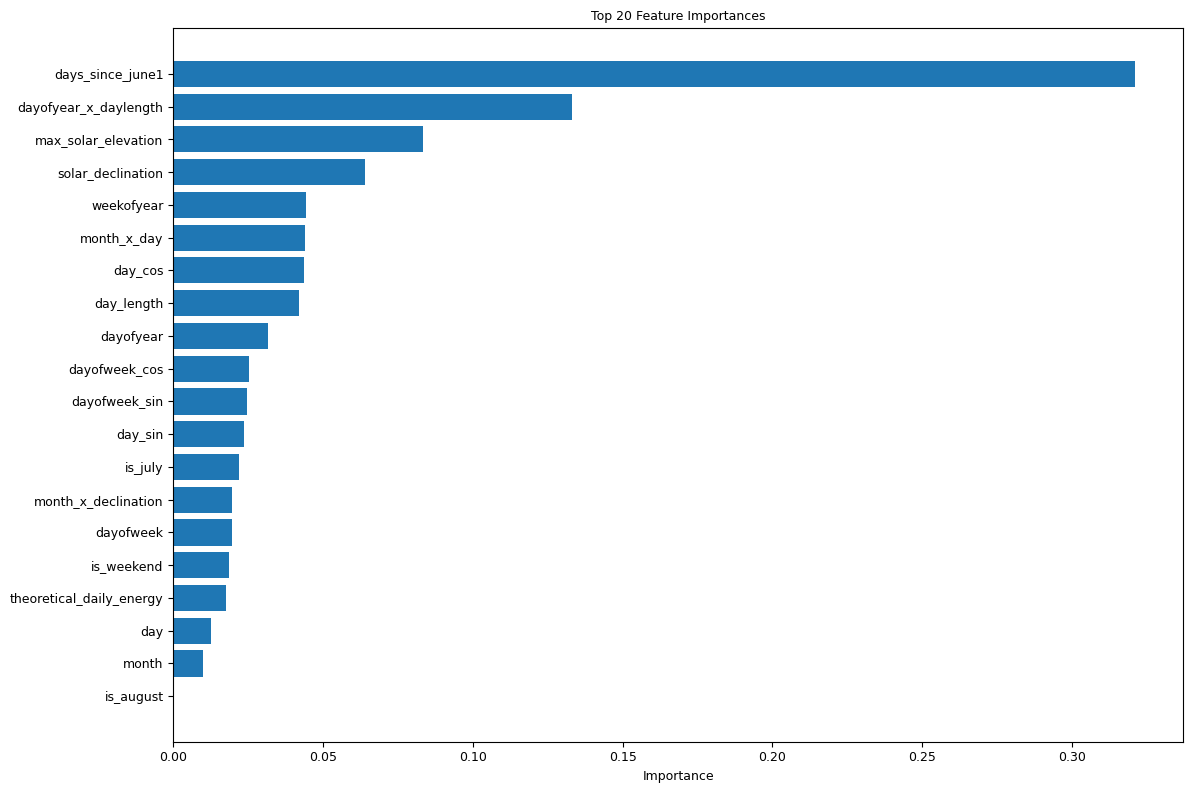

In [6]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print("=" * 50)
print(feature_importance.head(20).to_string())

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [7]:
# Validate model on validation set
val_pred = model.predict(X_val)

# Clip predictions to non-negative values
val_pred = np.clip(val_pred, 0, None)

# Calculate validation metrics
val_mae = mean_absolute_error(y_val, val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 10  # MWh
significant_mask = y_val >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((y_val[significant_mask] - val_pred[significant_mask]) / y_val[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (y_val == 0).sum()
low_gen_count = ((y_val > 0) & (y_val < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(y_val)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(y_val)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(y_val)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh")
print(f"  Max: {val_pred.max():.2f} MWh")
print(f"  Mean: {val_pred.mean():.2f} MWh")

Validation Set Performance:
MAE:  53829.58 MWh
RMSE: 59294.75 MWh
MAPE (generation >= 10 MWh): 26.37%

Data distribution in validation set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 0 (0.0%)
  Significant generation (>=10 MWh): 55 (100.0%)

Prediction range:
  Min: 138390.50 MWh
  Max: 146708.36 MWh
  Mean: 143579.27 MWh


In [8]:
# Test model on test set
test_pred = model.predict(X_test)

# Clip predictions to non-negative values
test_pred = np.clip(test_pred, 0, None)

# Calculate test metrics
test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 10  # MWh
significant_mask = y_test >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((y_test[significant_mask] - test_pred[significant_mask]) / y_test[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")
    
# Show additional info
zero_count = (y_test == 0).sum()
low_gen_count = ((y_test > 0) & (y_test < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(y_test)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(y_test)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(y_test)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {test_pred.min():.2f} MWh")
print(f"  Max: {test_pred.max():.2f} MWh")
print(f"  Mean: {test_pred.mean():.2f} MWh")

Test Set Performance:
MAE:  47321.26 MWh
RMSE: 51361.98 MWh
MAPE (generation >= 10 MWh): 23.96%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-10 MWh): 0 (0.0%)
  Significant generation (>=10 MWh): 28 (100.0%)

Prediction range:
  Min: 139368.80 MWh
  Max: 145226.20 MWh
  Mean: 143093.81 MWh


In [9]:
# Diagnostic: Analyze error distribution on validation set
val_df_analysis = val_df.copy()
val_df_analysis['predicted'] = val_pred
val_df_analysis['error'] = y_val.values - val_pred
val_df_analysis['abs_error'] = np.abs(val_df_analysis['error'])
val_df_analysis['pct_error'] = np.where(
    y_val.values >= 10, 
    np.abs(val_df_analysis['error'] / y_val.values) * 100,
    np.nan
)

print("Error Analysis on Validation Set:")
print("=" * 50)
print(f"\nActual generation statistics:")
print(val_df_analysis['generation'].describe())

print(f"\nPredicted generation statistics:")
print(pd.Series(val_pred).describe())

print(f"\nAbsolute error statistics:")
print(val_df_analysis['abs_error'].describe())

print(f"\nPercentage error statistics (excluding low generation):")
print(val_df_analysis['pct_error'].describe())

# Show some examples of high errors
print(f"\n5 Largest absolute errors:")
print(val_df_analysis.nlargest(5, 'abs_error')[['datetime', 'generation', 'predicted', 'error', 'pct_error']])

Error Analysis on Validation Set:

Actual generation statistics:
count        55.000000
mean     194417.581818
std       31053.851107
min      108345.000000
25%      170257.500000
50%      208290.000000
75%      217814.500000
max      234514.000000
Name: generation, dtype: float64

Predicted generation statistics:
count        55.000000
mean     143579.265625
std        1707.051758
min      138390.500000
25%      142655.304688
50%      143987.406250
75%      144894.570312
max      146708.359375
dtype: float64

Absolute error statistics:
count       55.000000
mean     53829.579261
std      25093.690238
min       5056.812500
25%      27481.875000
50%      65501.109375
75%      74565.953125
max      90526.593750
Name: abs_error, dtype: float64

Percentage error statistics (excluding low generation):
count    55.000000
mean     26.370966
std       9.922773
min       3.370736
25%      16.109966
50%      31.245312
75%      34.029096
max      38.601787
Name: pct_error, dtype: float64

5 Large

In [10]:
# Cell 10 - Modified to forecast only June-August 2025
# Create forecast for 2025 (June to August only)
print("Forecasting for 2025 (June to August only)...")
print("=" * 60)

# Create future dates for Jun-Aug 2025 (DAILY frequency)
future_dates = pd.date_range(start='2025-06-01', end='2025-08-31', freq='D')
future_df = pd.DataFrame({'datetime': future_dates})

print(f"Forecast period: {future_df['datetime'].min()} to {future_df['datetime'].max()}")
print(f"Total days to forecast: {len(future_df)}")

# Create features for 2025 summer
future_features = create_features(future_df)

# Prepare features for prediction
feature_cols_check = [col for col in feature_cols if col in future_features.columns]
print(f"\nFeatures available: {len(feature_cols_check)}/{len(feature_cols)}")

if len(feature_cols_check) != len(feature_cols):
    missing = set(feature_cols) - set(feature_cols_check)
    print(f"Missing features: {missing}")

X_future = future_features[feature_cols].copy()

# Check for any NaN values
nan_count = X_future.isna().sum().sum()
if nan_count > 0:
    print(f"WARNING: {nan_count} NaN values found")
    print("Filling NaN with 0...")
    X_future = X_future.fillna(0)
else:
    print("No NaN values - ready for prediction!")

# Make predictions
print("\nGenerating 2025 summer (Jun-Aug) daily forecasts...")
forecast_values = model.predict(X_future)

# Clip negative values
forecast_values = np.clip(forecast_values, 0, None)

# Create forecast dataframe
forecast_2025 = pd.DataFrame({
    'datetime': future_dates,
    'yhat': forecast_values
})

# Add month for analysis
forecast_2025['month'] = forecast_2025['datetime'].dt.month

print("\n" + "=" * 60)
print("FORECAST COMPLETE - SUMMER 2025")
print("=" * 60)
print(f"Total predictions: {len(forecast_2025)} days")
print(f"\nForecast statistics:")
print(f"  Min:  {forecast_2025['yhat'].min():.2f} MWh/day")
print(f"  Max:  {forecast_2025['yhat'].max():.2f} MWh/day")
print(f"  Mean: {forecast_2025['yhat'].mean():.2f} MWh/day")
print(f"  Median: {forecast_2025['yhat'].median():.2f} MWh/day")

# Check monthly pattern
print(f"\nAverage daily forecast by month:")
monthly_avg = forecast_2025.groupby('month')['yhat'].mean()
month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug'}
for month in [6, 7, 8]:
    if month in monthly_avg.index:
        print(f"  {month_names[month]}: {monthly_avg[month]:>8.2f} MWh/day")

Forecasting for 2025 (June to August only)...
Forecast period: 2025-06-01 00:00:00 to 2025-08-31 00:00:00
Total days to forecast: 92

Features available: 24/24
No NaN values - ready for prediction!

Generating 2025 summer (Jun-Aug) daily forecasts...

FORECAST COMPLETE - SUMMER 2025
Total predictions: 92 days

Forecast statistics:
  Min:  137490.22 MWh/day
  Max:  147090.72 MWh/day
  Mean: 142477.53 MWh/day
  Median: 142510.06 MWh/day

Average daily forecast by month:
  Jun: 142413.47 MWh/day
  Jul: 142934.22 MWh/day
  Aug: 142082.80 MWh/day


Disaggregating daily forecasts to hourly resolution...


Hourly weighting factors (normalized):
----------------------------------------
Hour  0:00 - Weight: 0.0000 (0.00%)
Hour  1:00 - Weight: 0.0000 (0.00%)
Hour  2:00 - Weight: 0.0000 (0.00%)
Hour  3:00 - Weight: 0.0000 (0.00%)
Hour  4:00 - Weight: 0.0000 (0.00%)
Hour  5:00 - Weight: 0.0000 (0.00%)
Hour  6:00 - Weight: 0.0000 (0.00%)
Hour  7:00 - Weight: 0.0135 (1.35%)
Hour  8:00 - Weight: 0.0367 (3.67%)
Hour  9:00 - Weight: 0.0632 (6.32%)
Hour 10:00 - Weight: 0.0888 (8.88%)
Hour 11:00 - Weight: 0.1099 (10.99%)
Hour 12:00 - Weight: 0.1237 (12.37%)
Hour 13:00 - Weight: 0.1285 (12.85%)
Hour 14:00 - Weight: 0.1237 (12.37%)
Hour 15:00 - Weight: 0.1099 (10.99%)
Hour 16:00 - Weight: 0.0888 (8.88%)
Hour 17:00 - Weight: 0.0632 (6.32%)
Hour 18:00 - Weight: 0.0367 (3.67%)
Hour 19:00 - Weight: 0.0135 (1.35%)
Hour 20:00 - Weight: 0.0000 (0.00%)
Hour 21:00 - Weight: 0.0000 (0.00%)
Hour 22:00 - Weight: 0.0000 (0.00%)
Hour 23:00 - Weight: 0.0000 (0.00%)


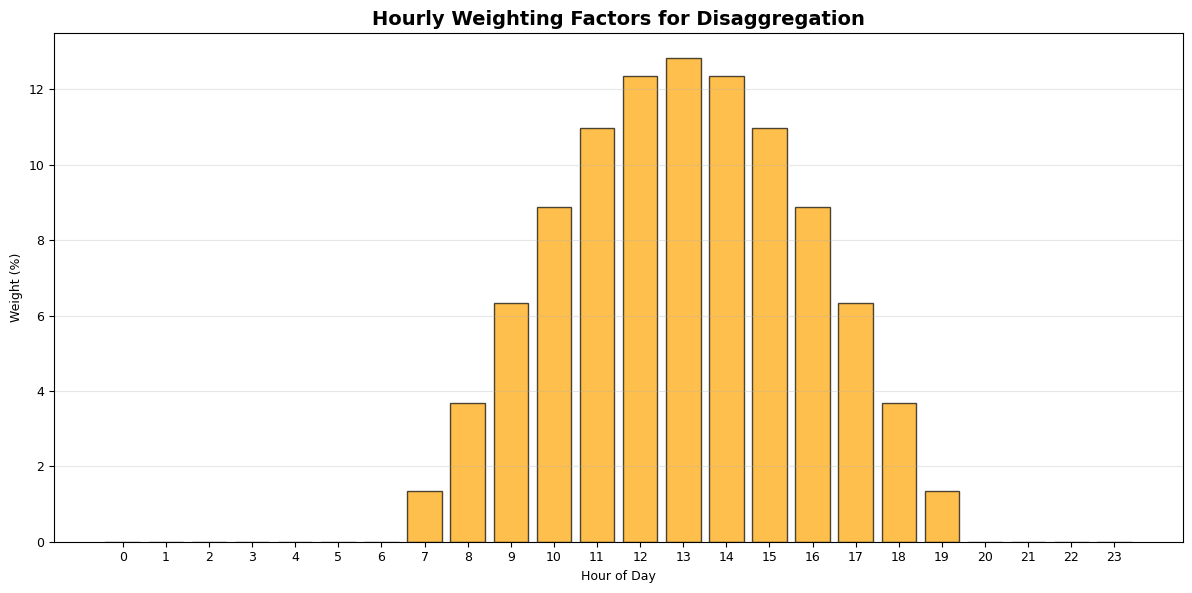


Creating hourly forecasts from daily aggregates...

Hourly forecast created:
  Total records: 2208 hours
  Period: 2025-06-01 00:00:00 to 2025-08-31 23:00:00
  Generation range: 0.00 to 18895.53 MWh/hour

Verifying disaggregation (checking daily totals)...
Maximum difference between original daily and disaggregated sum: 0.000000 MWh
✓ Disaggregation verified successfully!

Sample of hourly forecast (first day):
              datetime          yhat
0  2025-06-01 00:00:00  0.000000e+00
1  2025-06-01 01:00:00  0.000000e+00
2  2025-06-01 02:00:00  0.000000e+00
3  2025-06-01 03:00:00  0.000000e+00
4  2025-06-01 04:00:00  0.000000e+00
5  2025-06-01 05:00:00  0.000000e+00
6  2025-06-01 06:00:00  0.000000e+00
7  2025-06-01 07:00:00  1.938753e+03
8  2025-06-01 08:00:00  5.278692e+03
9  2025-06-01 09:00:00  9.093065e+03
10 2025-06-01 10:00:00  1.276839e+04
11 2025-06-01 11:00:00  1.579541e+04
12 2025-06-01 12:00:00  1.777972e+04
13 2025-06-01 13:00:00  1.846997e+04
14 2025-06-01 14:00:00  1.777

In [11]:
# Disaggregate daily forecasts to hourly using solar irradiation pattern
print("Disaggregating daily forecasts to hourly resolution...")
print("=" * 60)

#latitude = 40.4  is Spain
def create_hourly_weights(latitude=40.4):
    """
    Create hourly weighting factors based on typical solar irradiation pattern
    Returns normalized weights for 24 hours (sum = 1)
    """
    # Typical solar generation pattern (bell curve centered at solar noon)
    # Peak generation around 12:00-14:00, zero at night
    hours = np.arange(24)
    
    # Solar elevation angle approximation (simplified)
    # Peak at hour 13 (1 PM solar time), zero before 6 AM and after 8 PM
    weights = np.zeros(24)
    
    # Define sunrise and sunset hours (approximate for summer)
    sunrise_hour = 6
    sunset_hour = 20
    
    for hour in range(24):
        if sunrise_hour <= hour <= sunset_hour:
            # Use a sine curve to model solar irradiation
            # Peak at solar noon (around 13:00)
            angle = np.pi * (hour - sunrise_hour) / (sunset_hour - sunrise_hour)
            weights[hour] = np.sin(angle) ** 1.5  # Power factor for sharper peak
        else:
            weights[hour] = 0
    
    # Normalize so that sum of weights = 1
    weights = weights / weights.sum()
    
    return weights

# Create hourly weights
hourly_weights = create_hourly_weights()

# Display the weights
print("Hourly weighting factors (normalized):")
print("-" * 40)
for hour in range(24):
    print(f"Hour {hour:2d}:00 - Weight: {hourly_weights[hour]:.4f} ({hourly_weights[hour]*100:.2f}%)")

# Visualize the weights
plt.figure(figsize=(12, 6))
plt.bar(range(24), hourly_weights * 100, alpha=0.7, color='orange', edgecolor='black')
plt.title('Hourly Weighting Factors for Disaggregation', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Weight (%)')
plt.xticks(range(24))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Disaggregate daily forecasts to hourly
print("\n" + "=" * 60)
print("Creating hourly forecasts from daily aggregates...")

hourly_forecast_list = []

for idx, row in forecast_2025.iterrows():
    daily_date = row['datetime']
    daily_total = row['yhat']
    
    # Create 24 hourly records for this day
    for hour in range(24):
        hourly_datetime = daily_date + pd.Timedelta(hours=hour)
        hourly_generation = daily_total * hourly_weights[hour]
        
        hourly_forecast_list.append({
            'datetime': hourly_datetime,
            'yhat': hourly_generation
        })

# Create hourly forecast dataframe
forecast_2025_hourly = pd.DataFrame(hourly_forecast_list)

print(f"\nHourly forecast created:")
print(f"  Total records: {len(forecast_2025_hourly)} hours")
print(f"  Period: {forecast_2025_hourly['datetime'].min()} to {forecast_2025_hourly['datetime'].max()}")
print(f"  Generation range: {forecast_2025_hourly['yhat'].min():.2f} to {forecast_2025_hourly['yhat'].max():.2f} MWh/hour")

# Verify that daily totals match
print("\nVerifying disaggregation (checking daily totals)...")
forecast_2025_hourly['date'] = forecast_2025_hourly['datetime'].dt.date
daily_check = forecast_2025_hourly.groupby('date')['yhat'].sum().reset_index()
daily_check.columns = ['date', 'hourly_sum']

forecast_2025['date'] = forecast_2025['datetime'].dt.date
comparison_check = pd.merge(
    forecast_2025[['date', 'yhat']], 
    daily_check, 
    on='date'
)
comparison_check['difference'] = comparison_check['yhat'] - comparison_check['hourly_sum']

max_diff = comparison_check['difference'].abs().max()
print(f"Maximum difference between original daily and disaggregated sum: {max_diff:.6f} MWh")
if max_diff < 0.001:
    print("✓ Disaggregation verified successfully!")
else:
    print("⚠ Warning: Significant difference detected in disaggregation")

print("\nSample of hourly forecast (first day):")
print(forecast_2025_hourly.head(24)[['datetime', 'yhat']])


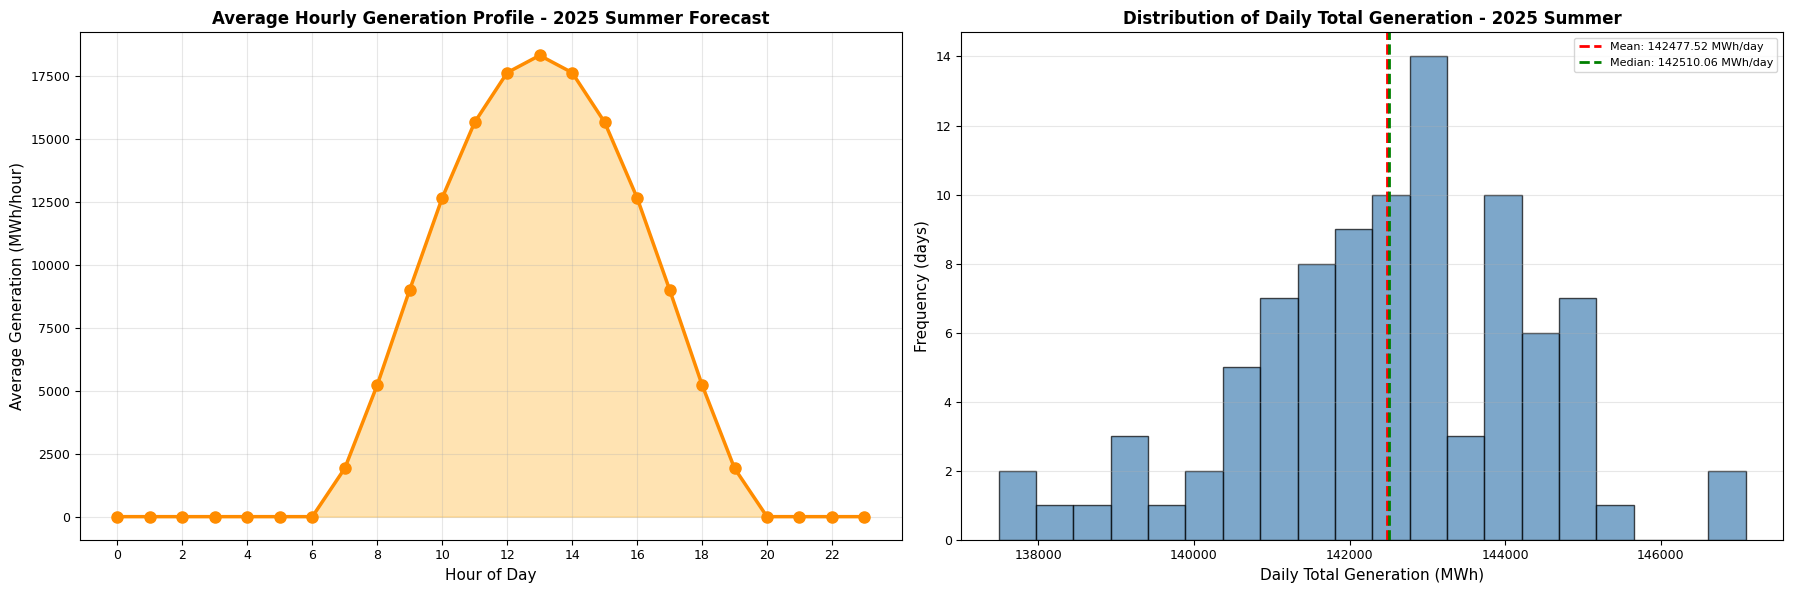


Daily total statistics from hourly forecast:
  Mean: 142477.52 MWh/day
  Median: 142510.06 MWh/day
  Std: 1866.91 MWh/day
  Min: 137490.22 MWh/day
  Max: 147090.72 MWh/day


In [12]:
# Additional hourly pattern visualization
# Show average hourly profile across all days
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Average hourly generation pattern
ax1 = axes[0]
hourly_avg_pattern = forecast_2025_hourly.copy()
hourly_avg_pattern['hour'] = hourly_avg_pattern['datetime'].dt.hour
hour_profile = hourly_avg_pattern.groupby('hour')['yhat'].mean()

ax1.plot(hour_profile.index, hour_profile.values, marker='o', linewidth=2.5, markersize=8, color='darkorange')
ax1.fill_between(hour_profile.index, 0, hour_profile.values, alpha=0.3, color='orange')
ax1.set_title('Average Hourly Generation Profile - 2025 Summer Forecast', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hour of Day', fontsize=11)
ax1.set_ylabel('Average Generation (MWh/hour)', fontsize=11)
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3)

# Right plot: Distribution of daily totals
ax2 = axes[1]
daily_totals = forecast_2025_hourly.copy()
daily_totals['date'] = daily_totals['datetime'].dt.date
daily_sums = daily_totals.groupby('date')['yhat'].sum()

ax2.hist(daily_sums, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(daily_sums.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {daily_sums.mean():.2f} MWh/day')
ax2.axvline(daily_sums.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {daily_sums.median():.2f} MWh/day')
ax2.set_title('Distribution of Daily Total Generation - 2025 Summer', fontsize=12, fontweight='bold')
ax2.set_xlabel('Daily Total Generation (MWh)', fontsize=11)
ax2.set_ylabel('Frequency (days)', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nDaily total statistics from hourly forecast:")
print(f"  Mean: {daily_sums.mean():.2f} MWh/day")
print(f"  Median: {daily_sums.median():.2f} MWh/day")
print(f"  Std: {daily_sums.std():.2f} MWh/day")
print(f"  Min: {daily_sums.min():.2f} MWh/day")
print(f"  Max: {daily_sums.max():.2f} MWh/day")

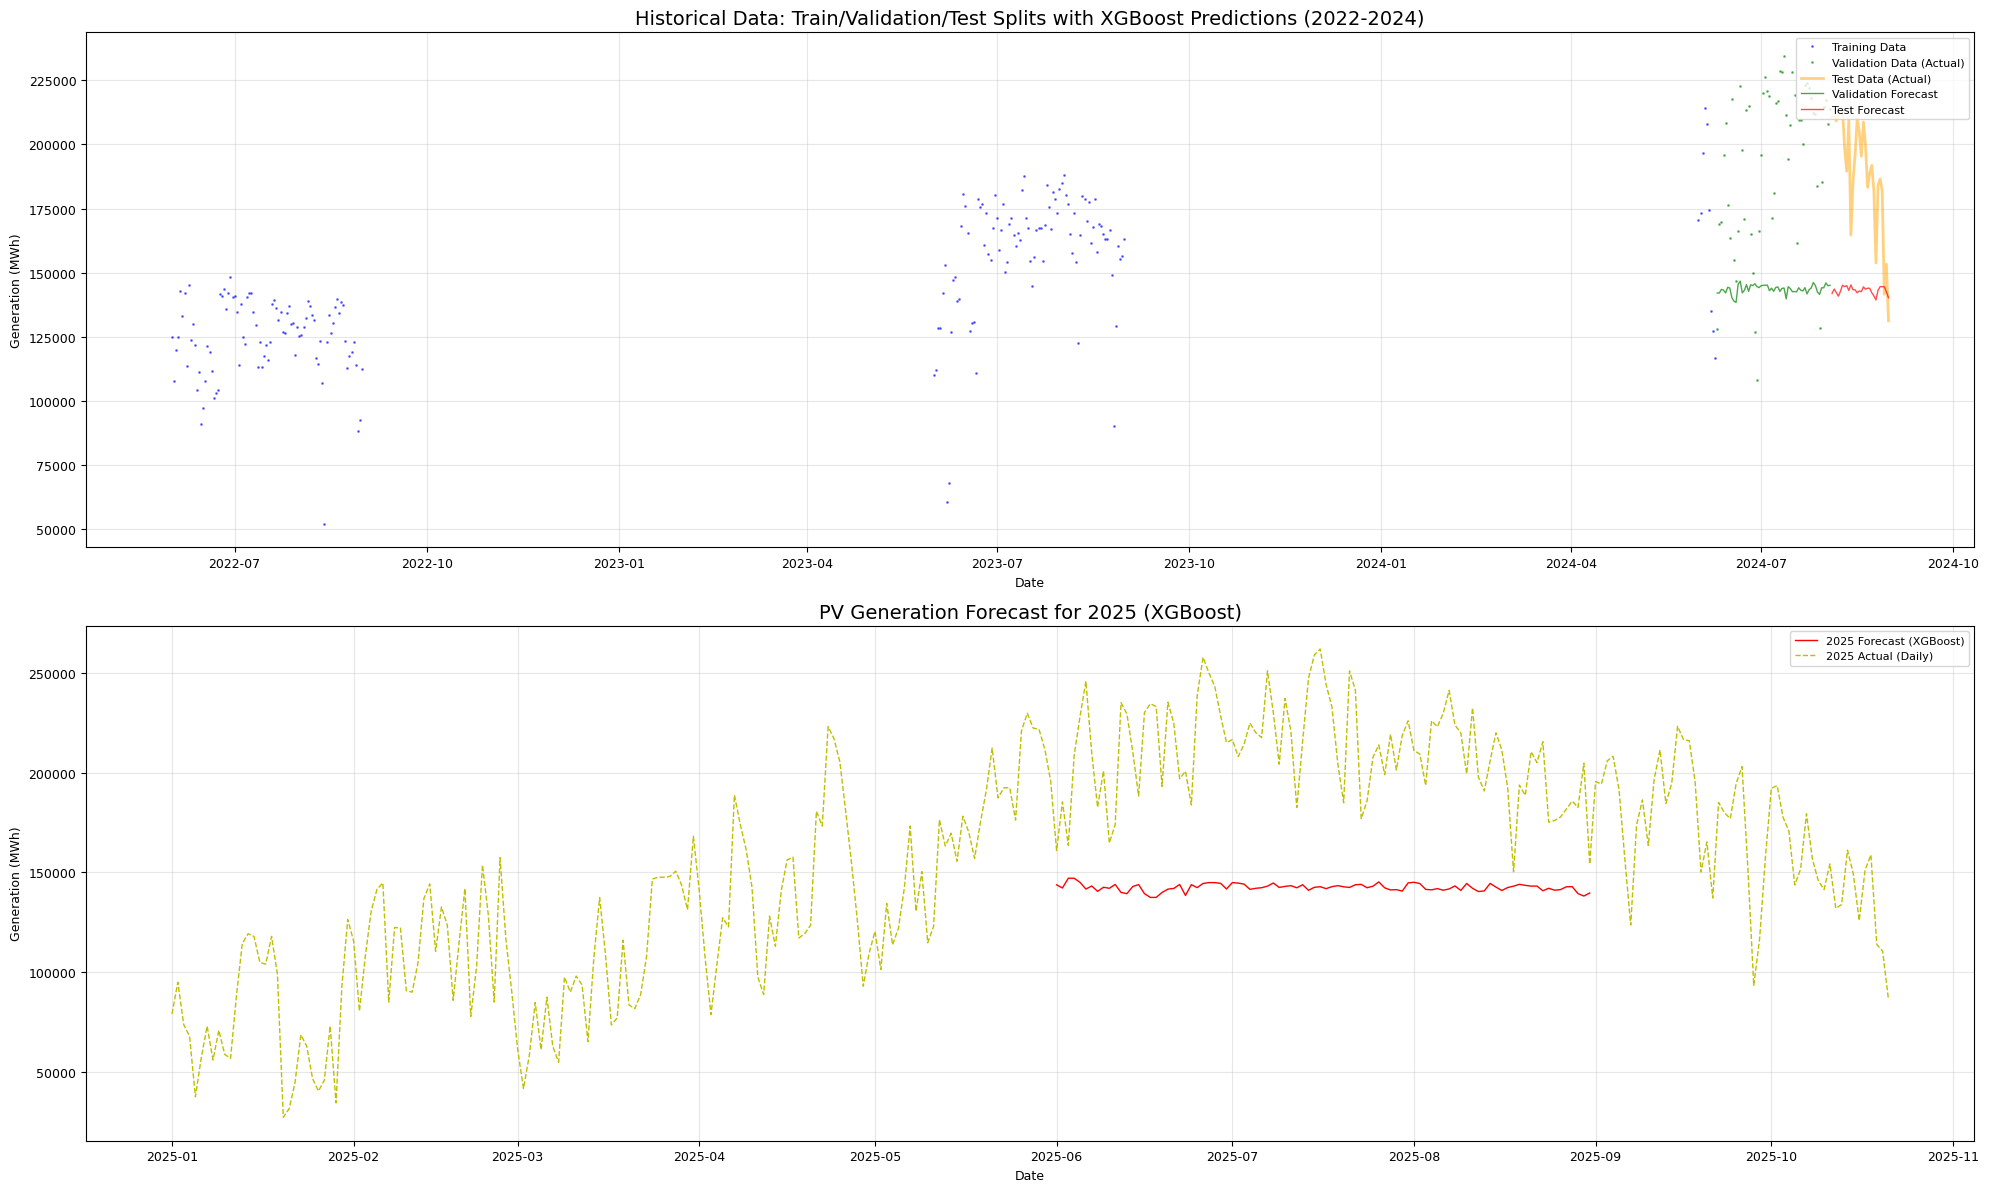

In [13]:
# Visualize train/val/test splits and model performance
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits
ax1 = axes[0]
ax1.plot(train_df['datetime'], train_df['generation'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['datetime'], val_df['generation'], 'g.', label='Validation Data (Actual)', alpha=0.5, markersize=2)
ax1.plot(test_df['datetime'], test_df['generation'], 'orange', label='Test Data (Actual)', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_df['datetime'].values, val_pred, 'g-', label='Validation Forecast', linewidth=1, alpha=0.7)
ax1.plot(test_df['datetime'].values, test_pred, 'r-', label='Test Forecast', linewidth=1, alpha=0.7)

ax1.set_title('Historical Data: Train/Validation/Test Splits with XGBoost Predictions (2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast
ax2 = axes[1]
ax2.plot(forecast_2025['datetime'], forecast_2025['yhat'], 'r-', label='2025 Forecast (XGBoost)', linewidth=1)

# Load actual 2025 data
df_2025_actual = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025_actual['datetime'] = pd.to_datetime(df_2025_actual['datetime'])
df_2025_actual['generation'] = df_2025_actual['Generation (MWh)']

# Create separate aggregated dataframe for daily actual (without modifying original)
df_2025_actual_daily = df_2025_actual.copy()
df_2025_actual_daily['date'] = df_2025_actual_daily['datetime'].dt.date
df_2025_actual_daily = df_2025_actual_daily.groupby('date').agg({
    'generation': 'sum'
}).reset_index()
df_2025_actual_daily['datetime'] = pd.to_datetime(df_2025_actual_daily['date'])

# Plot daily actual data
ax2.plot(df_2025_actual_daily['datetime'], df_2025_actual_daily['generation'], 
         'y--', label='2025 Actual (Daily)', linewidth=1)

ax2.set_title('PV Generation Forecast for 2025 (XGBoost)', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


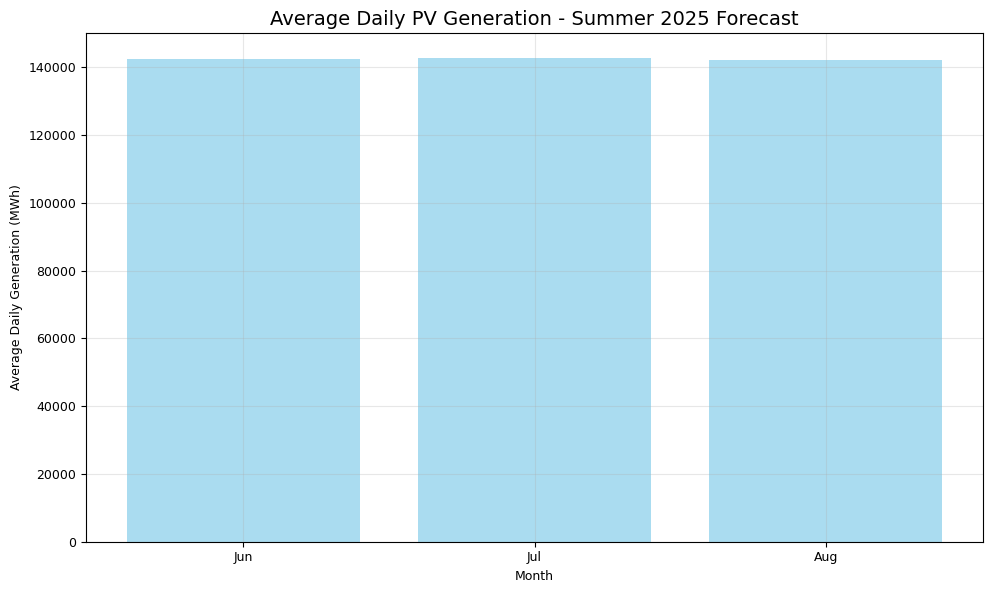

Monthly Generation Summary (Summer 2025):
Jun: 142413.47 MWh/day
Jul: 142934.22 MWh/day
Aug: 142082.80 MWh/day


In [14]:
# Cell 12 - Modified for summer months only
# Analyze seasonal patterns in the forecast (Summer only)
forecast_2025['month'] = forecast_2025['datetime'].dt.month

# Monthly average generation
monthly_avg = forecast_2025.groupby('month')['yhat'].mean()

# Create plot for monthly pattern (Jun-Aug only)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot monthly pattern
month_labels = ['Jun', 'Jul', 'Aug']
ax.bar(range(len(monthly_avg)), monthly_avg.values, alpha=0.7, color='skyblue')
ax.set_title('Average Daily PV Generation - Summer 2025 Forecast', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Average Daily Generation (MWh)')
ax.set_xticks(range(len(monthly_avg)))
ax.set_xticklabels(month_labels)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Monthly Generation Summary (Summer 2025):")
print("=" * 50)
month_names = {6: 'Jun', 7: 'Jul', 8: 'Aug'}
for month, value in monthly_avg.items():
    print(f"{month_names[month]}: {value:.2f} MWh/day")

In [15]:
# Cell 13 - Modified export filename
# Export 2025 forecast to CSV
forecast_export = forecast_2025[['datetime', 'yhat']].copy()
forecast_export['date'] = forecast_export['datetime'].dt.strftime('%Y-%m-%d')
forecast_export = forecast_export[['date', 'yhat']].rename(columns={
    'date': 'Date',
    'yhat': 'Forecast_Generation_MWh'
})

output_file = 'pv_forecast_2025_summer_xgboost_agg.csv'
forecast_export.to_csv(output_file, index=False)
print(f"2025 summer forecast (Jun-Aug) exported to: {output_file}")
print(f"\nSummary statistics of 2025 summer forecast:")
print(forecast_export.describe())

2025 summer forecast (Jun-Aug) exported to: pv_forecast_2025_summer_xgboost_agg.csv

Summary statistics of 2025 summer forecast:
       Forecast_Generation_MWh
count                92.000000
mean             142477.531250
std                1866.910156
min              137490.218750
25%              141381.050781
50%              142510.062500
75%              143843.734375
max              147090.718750


In [16]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025

,datetime,Area,Production Type,Generation (MWh)
0,2025-01-01 00:00:00,BZN|ES,Solar,4.000000
1,2025-01-01 01:00:00,BZN|ES,Solar,4.000000
2,2025-01-01 02:00:00,BZN|ES,Solar,4.000000
3,2025-01-01 03:00:00,BZN|ES,Solar,4.000000
4,2025-01-01 04:00:00,BZN|ES,Solar,4.000000
...,...,...,...,...
7047,2025-10-21 16:00:00,BZN|ES,Solar,11324.000000
7048,2025-10-21 17:00:00,BZN|ES,Solar,8866.000000
7049,2025-10-21 18:00:00,BZN|ES,Solar,4370.000000
7050,2025-10-21 19:00:00,BZN|ES,Solar,688.000000


In [17]:
# Cell 15 - Modified to load hourly 2025 data and compare with disaggregated hourly forecast
# Load actual 2025 HOURLY data and prepare for comparison (June-August only)
print("Loading actual 2025 HOURLY data for comparison...")
print("=" * 60)

df_2025_actual_hourly = pd.read_csv("datasets/Actual_all/actual_PV_2025.csv")
df_2025_actual_hourly['datetime'] = pd.to_datetime(df_2025_actual_hourly['datetime'])
df_2025_actual_hourly['generation'] = df_2025_actual_hourly['Generation (MWh)']

# Filter for June-August 2025 only
df_2025_actual_hourly['month'] = df_2025_actual_hourly['datetime'].dt.month
df_2025_actual_hourly = df_2025_actual_hourly[df_2025_actual_hourly['month'].isin([6, 7, 8])].copy()

# Keep hourly data (no aggregation)
df_2025_actual_hourly = df_2025_actual_hourly[['datetime', 'generation']].sort_values('datetime')

print(f"2025 actual summer data loaded (HOURLY):")
print(f"  Period: {df_2025_actual_hourly['datetime'].min()} to {df_2025_actual_hourly['datetime'].max()}")
print(f"  Total records: {len(df_2025_actual_hourly)} hours")
print(f"  Data range: {df_2025_actual_hourly['generation'].min():.2f} to {df_2025_actual_hourly['generation'].max():.2f} MWh/hour")

# Merge hourly forecast with hourly actual 2025 data
comparison = pd.merge(
    forecast_2025_hourly[['datetime', 'yhat']], 
    df_2025_actual_hourly[['datetime', 'generation']], 
    on='datetime', 
    how='inner'
)

print(f"\nMatched records: {len(comparison)} hours (June-August 2025)")

# Calculate hourly metrics
mae = mean_absolute_error(comparison['generation'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['generation'], comparison['yhat']))

# Calculate MAPE (excluding very low generation hours)
threshold = 10  # MWh/hour (daytime generation threshold)
significant_mask = comparison['generation'] >= threshold
if significant_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['generation'][significant_mask] - comparison['yhat'][significant_mask]) / comparison['generation'][significant_mask])) * 100
else:
    mape = np.nan

print(f"\n2025 Summer Forecast Performance Metrics (XGBoost - HOURLY):")
print("=" * 50)
print(f"MAE:  {mae:.2f} MWh/hour")
print(f"RMSE: {rmse:.2f} MWh/hour")
if not np.isnan(mape):
    print(f"MAPE (generation >= {threshold} MWh/hour): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show data ranges
print(f"\nData ranges:")
print(f"  Actual values: {comparison['generation'].min():.2f} to {comparison['generation'].max():.2f} MWh/hour")
print(f"  Forecasted values: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh/hour")

# Show daytime vs nighttime breakdown
comparison['hour'] = comparison['datetime'].dt.hour
daytime_mask = (comparison['hour'] >= 6) & (comparison['hour'] <= 20)
print(f"\nDaytime hours (6-20): {daytime_mask.sum()} records")
print(f"Nighttime hours: {(~daytime_mask).sum()} records")

Loading actual 2025 HOURLY data for comparison...
2025 actual summer data loaded (HOURLY):
  Period: 2025-06-01 00:00:00 to 2025-08-31 23:00:00
  Total records: 2208 hours
  Data range: 7.00 to 23999.00 MWh/hour

Matched records: 2208 hours (June-August 2025)

2025 Summer Forecast Performance Metrics (XGBoost - HOURLY):
MAE:  3137.99 MWh/hour
RMSE: 4804.45 MWh/hour
MAPE (generation >= 10 MWh/hour): 84.39%

Data ranges:
  Actual values: 7.00 to 23999.00 MWh/hour
  Forecasted values: 0.00 to 18895.53 MWh/hour

Daytime hours (6-20): 1380 records
Nighttime hours: 828 records


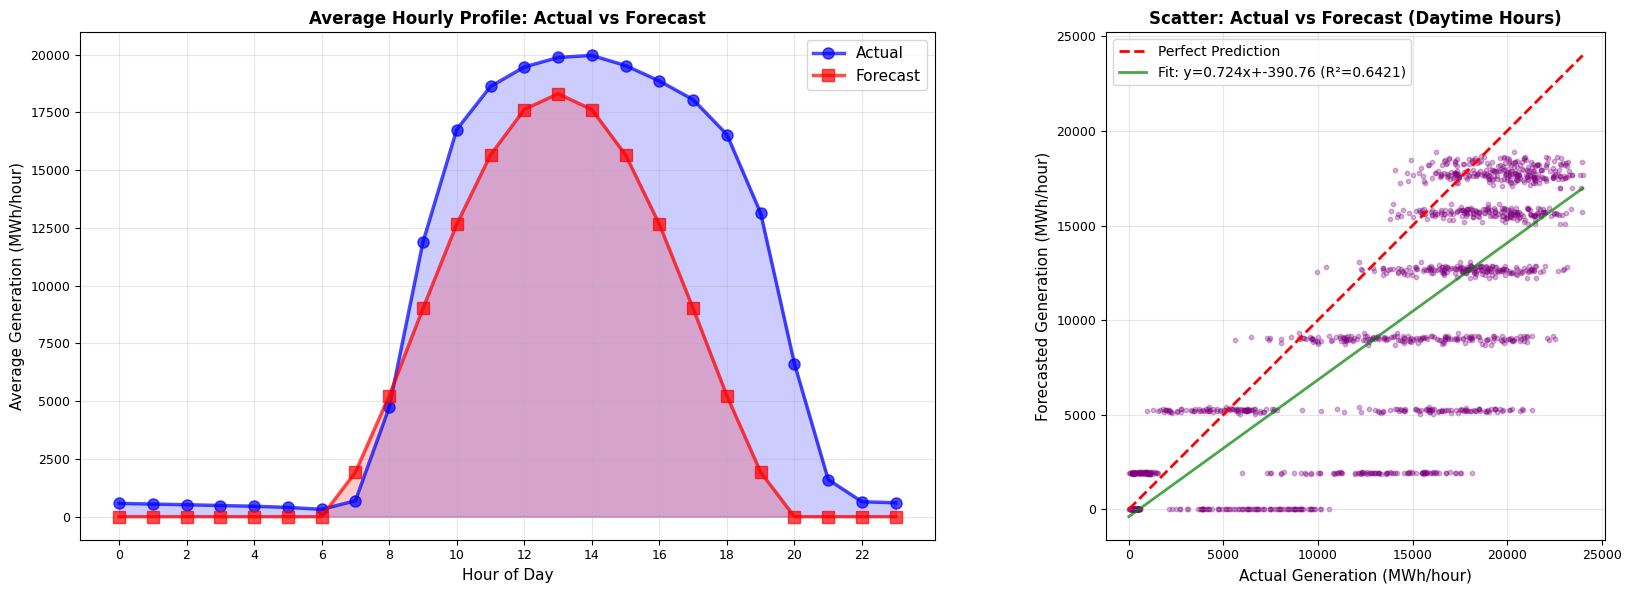


Hourly Profile Comparison:
 Hour  Actual_Avg  Forecast_Avg  Difference  Pct_Diff
    0      575.23          0.00     -575.23   -100.00
    1      545.60          0.00     -545.60   -100.00
    2      516.49          0.00     -516.49   -100.00
    3      482.73          0.00     -482.73   -100.00
    4      450.49          0.00     -450.49   -100.00
    5      402.21          0.00     -402.21   -100.00
    6      316.66          0.00     -316.66   -100.00
    7      689.84       1921.22     1231.38    178.50
    8     4728.93       5230.94      502.01     10.62
    9    11883.47       9010.82    -2872.65    -24.17
   10    16752.59      12652.89    -4099.70    -24.47
   11    18617.28      15652.54    -2964.75    -15.92
   12    19460.63      17618.90    -1841.73     -9.46
   13    19871.42      18302.91    -1568.52     -7.89
   14    19961.46      17618.90    -2342.56    -11.74
   15    19521.80      15652.54    -3869.27    -19.82
   16    18855.70      12652.89    -6202.80    -32.90


In [18]:
# Hourly pattern comparison: Actual vs Forecast
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Average hourly profiles comparison
ax1 = axes[0]
actual_hourly_profile = comparison.groupby('hour')['generation'].mean()
forecast_hourly_profile = comparison.groupby('hour')['yhat'].mean()

ax1.plot(actual_hourly_profile.index, actual_hourly_profile.values, marker='o', 
         linewidth=2.5, markersize=8, color='blue', label='Actual', alpha=0.7)
ax1.plot(forecast_hourly_profile.index, forecast_hourly_profile.values, marker='s', 
         linewidth=2.5, markersize=8, color='red', label='Forecast', alpha=0.7)
ax1.fill_between(actual_hourly_profile.index, 0, actual_hourly_profile.values, alpha=0.2, color='blue')
ax1.fill_between(forecast_hourly_profile.index, 0, forecast_hourly_profile.values, alpha=0.2, color='red')
ax1.set_title('Average Hourly Profile: Actual vs Forecast', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hour of Day', fontsize=11)
ax1.set_ylabel('Average Generation (MWh/hour)', fontsize=11)
ax1.set_xticks(range(0, 24, 2))
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Right plot: Scatter plot of actual vs forecast (daytime hours only)
ax2 = axes[1]
daytime_comparison = comparison[(comparison['hour'] >= 6) & (comparison['hour'] <= 20)]
ax2.scatter(daytime_comparison['generation'], daytime_comparison['yhat'], 
           alpha=0.3, s=10, color='purple')

# Add perfect prediction line
max_val = max(daytime_comparison['generation'].max(), daytime_comparison['yhat'].max())
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Add regression line
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(
    daytime_comparison['generation'], daytime_comparison['yhat']
)
line_x = np.array([0, max_val])
line_y = slope * line_x + intercept
ax2.plot(line_x, line_y, 'g-', linewidth=2, alpha=0.7, 
         label=f'Fit: y={slope:.3f}x+{intercept:.2f} (R²={r_value**2:.4f})')

ax2.set_title('Scatter: Actual vs Forecast (Daytime Hours)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Actual Generation (MWh/hour)', fontsize=11)
ax2.set_ylabel('Forecasted Generation (MWh/hour)', fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("\nHourly Profile Comparison:")
profile_comparison = pd.DataFrame({
    'Hour': actual_hourly_profile.index,
    'Actual_Avg': actual_hourly_profile.values.round(2),
    'Forecast_Avg': forecast_hourly_profile.values.round(2),
    'Difference': (forecast_hourly_profile.values - actual_hourly_profile.values).round(2),
    'Pct_Diff': ((forecast_hourly_profile.values - actual_hourly_profile.values) / 
                 actual_hourly_profile.values * 100).round(2)
})
print(profile_comparison.to_string(index=False))

In [19]:
# Detailed analysis of 2025 hourly forecast performance
print("Detailed Hourly Performance Analysis")
print("=" * 60)

# Check for zero/low values in actual data
zero_counts = (comparison['generation'] == 0).sum()
low_gen_threshold = 1  # MWh/hour
low_counts = ((comparison['generation'] > 0) & (comparison['generation'] < low_gen_threshold)).sum()

print(f"Number of zero values in actual data: {zero_counts} ({zero_counts/len(comparison)*100:.1f}%)")
print(f"Number of low generation values (0-{low_gen_threshold} MWh): {low_counts} ({low_counts/len(comparison)*100:.1f}%)")

# Calculate metrics with handling for zero values
mae = mean_absolute_error(comparison['generation'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['generation'], comparison['yhat']))

# MAPE calculation excluding nighttime (zero/very low values)
daytime_threshold = 5  # MWh/hour
daytime_mask = comparison['generation'] >= daytime_threshold
if daytime_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['generation'][daytime_mask] - comparison['yhat'][daytime_mask]) / comparison['generation'][daytime_mask])) * 100
else:
    mape = np.nan

print(f"\nOverall Hourly Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f} MWh/hour")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} MWh/hour")
if not np.isnan(mape):
    print(f"Mean Absolute Percentage Error (MAPE, daytime only >= {daytime_threshold} MWh): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

# R² Score
from sklearn.metrics import r2_score
r2 = r2_score(comparison['generation'], comparison['yhat'])
print(f"R² Score: {r2:.4f}")

# Daytime-only metrics (6 AM to 8 PM)
comparison['hour'] = comparison['datetime'].dt.hour
daytime_hours_mask = (comparison['hour'] >= 6) & (comparison['hour'] <= 20)
daytime_data = comparison[daytime_hours_mask]

mae_daytime = mean_absolute_error(daytime_data['generation'], daytime_data['yhat'])
rmse_daytime = np.sqrt(mean_squared_error(daytime_data['generation'], daytime_data['yhat']))
r2_daytime = r2_score(daytime_data['generation'], daytime_data['yhat'])

print(f"\nDaytime Hours Only (6 AM - 8 PM) Metrics:")
print(f"MAE: {mae_daytime:.2f} MWh/hour")
print(f"RMSE: {rmse_daytime:.2f} MWh/hour")
print(f"R² Score: {r2_daytime:.4f}")

# Show min/max values
print(f"\nData ranges (all hours):")
print(f"Actual values: {comparison['generation'].min():.2f} to {comparison['generation'].max():.2f} MWh/hour")
print(f"Forecasted values: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh/hour")

# Hourly pattern analysis
print(f"\nAverage generation by hour of day:")
hourly_avg = comparison.groupby('hour').agg({
    'generation': 'mean',
    'yhat': 'mean'
}).round(2)
hourly_avg.columns = ['Actual_Avg', 'Forecast_Avg']
hourly_avg['Difference'] = (hourly_avg['Forecast_Avg'] - hourly_avg['Actual_Avg']).round(2)
print(hourly_avg)

Detailed Hourly Performance Analysis
Number of zero values in actual data: 0 (0.0%)
Number of low generation values (0-1 MWh): 0 (0.0%)

Overall Hourly Metrics:
Mean Absolute Error (MAE): 3137.99 MWh/hour
Root Mean Square Error (RMSE): 4804.45 MWh/hour
Mean Absolute Percentage Error (MAPE, daytime only >= 5 MWh): 84.40%
R² Score: 0.6811

Daytime Hours Only (6 AM - 8 PM) Metrics:
MAE: 4632.45 MWh/hour
RMSE: 6047.12 MWh/hour
R² Score: 0.2984

Data ranges (all hours):
Actual values: 7.00 to 23999.00 MWh/hour
Forecasted values: 0.00 to 18895.53 MWh/hour

Average generation by hour of day:
      Actual_Avg  Forecast_Avg  Difference
hour                                      
0         575.23          0.00     -575.23
1         545.60          0.00     -545.60
2         516.49          0.00     -516.49
3         482.73          0.00     -482.73
4         450.49          0.00     -450.49
5         402.21          0.00     -402.21
6         316.66          0.00     -316.66
7         689.84     

In [20]:
# Cell 17 - Normalized metrics for HOURLY data
# Calculate installed capacity (using 95th percentile of actual values as proxy)
installed_capacity_hourly = comparison['generation'].quantile(0.95)

# Calculate metrics
hourly_mae = mean_absolute_error(comparison['generation'], comparison['yhat'])
hourly_rmse = np.sqrt(mean_squared_error(comparison['generation'], comparison['yhat']))
nmae = hourly_mae / installed_capacity_hourly * 100
nrmse = hourly_rmse / installed_capacity_hourly * 100

# Calculate skill score using persistence model (previous hour as forecast)
persistence_forecast = comparison['generation'].shift(1)  # Shift by 1 hour
valid_indices = ~persistence_forecast.isna()
if valid_indices.sum() > 0:
    persistence_mse = mean_squared_error(
        comparison['generation'][valid_indices], 
        persistence_forecast[valid_indices]
    )
    model_mse = mean_squared_error(comparison['generation'], comparison['yhat'])
    skill_score = (1 - model_mse/persistence_mse) * 100
else:
    skill_score = np.nan

print("Hourly Forecast Metrics:")
print("=======================================")
print(f"Installed Capacity (95th percentile): {installed_capacity_hourly:.2f} MWh/hour")
print(f"MAE: {hourly_mae:.2f} MWh/hour")
print(f"RMSE: {hourly_rmse:.2f} MWh/hour")
print(f"Normalized MAE: {nmae:.2f}% of installed capacity")
print(f"Normalized RMSE: {nrmse:.2f}% of installed capacity")
if not np.isnan(skill_score):
    print(f"Forecast Skill Score: {skill_score:.2f}% improvement over persistence model")
else:
    print(f"Forecast Skill Score: N/A")

# Additional daytime-only metrics
daytime_mask = (comparison['hour'] >= 6) & (comparison['hour'] <= 20)
daytime_comparison = comparison[daytime_mask]
installed_capacity_daytime = daytime_comparison['generation'].quantile(0.95)
mae_daytime = mean_absolute_error(daytime_comparison['generation'], daytime_comparison['yhat'])
rmse_daytime = np.sqrt(mean_squared_error(daytime_comparison['generation'], daytime_comparison['yhat']))
nmae_daytime = mae_daytime / installed_capacity_daytime * 100
nrmse_daytime = rmse_daytime / installed_capacity_daytime * 100

print(f"\nDaytime Hours Only (6 AM - 8 PM) Metrics:")
print(f"Installed Capacity (95th percentile): {installed_capacity_daytime:.2f} MWh/hour")
print(f"MAE: {mae_daytime:.2f} MWh/hour")
print(f"RMSE: {rmse_daytime:.2f} MWh/hour")
print(f"Normalized MAE: {nmae_daytime:.2f}% of installed capacity")
print(f"Normalized RMSE: {nrmse_daytime:.2f}% of installed capacity")

Hourly Forecast Metrics:
Installed Capacity (95th percentile): 21443.00 MWh/hour
MAE: 3137.99 MWh/hour
RMSE: 4804.45 MWh/hour
Normalized MAE: 14.63% of installed capacity
Normalized RMSE: 22.41% of installed capacity
Forecast Skill Score: -184.29% improvement over persistence model

Daytime Hours Only (6 AM - 8 PM) Metrics:
Installed Capacity (95th percentile): 22028.15 MWh/hour
MAE: 4632.45 MWh/hour
RMSE: 6047.12 MWh/hour
Normalized MAE: 21.03% of installed capacity
Normalized RMSE: 27.45% of installed capacity


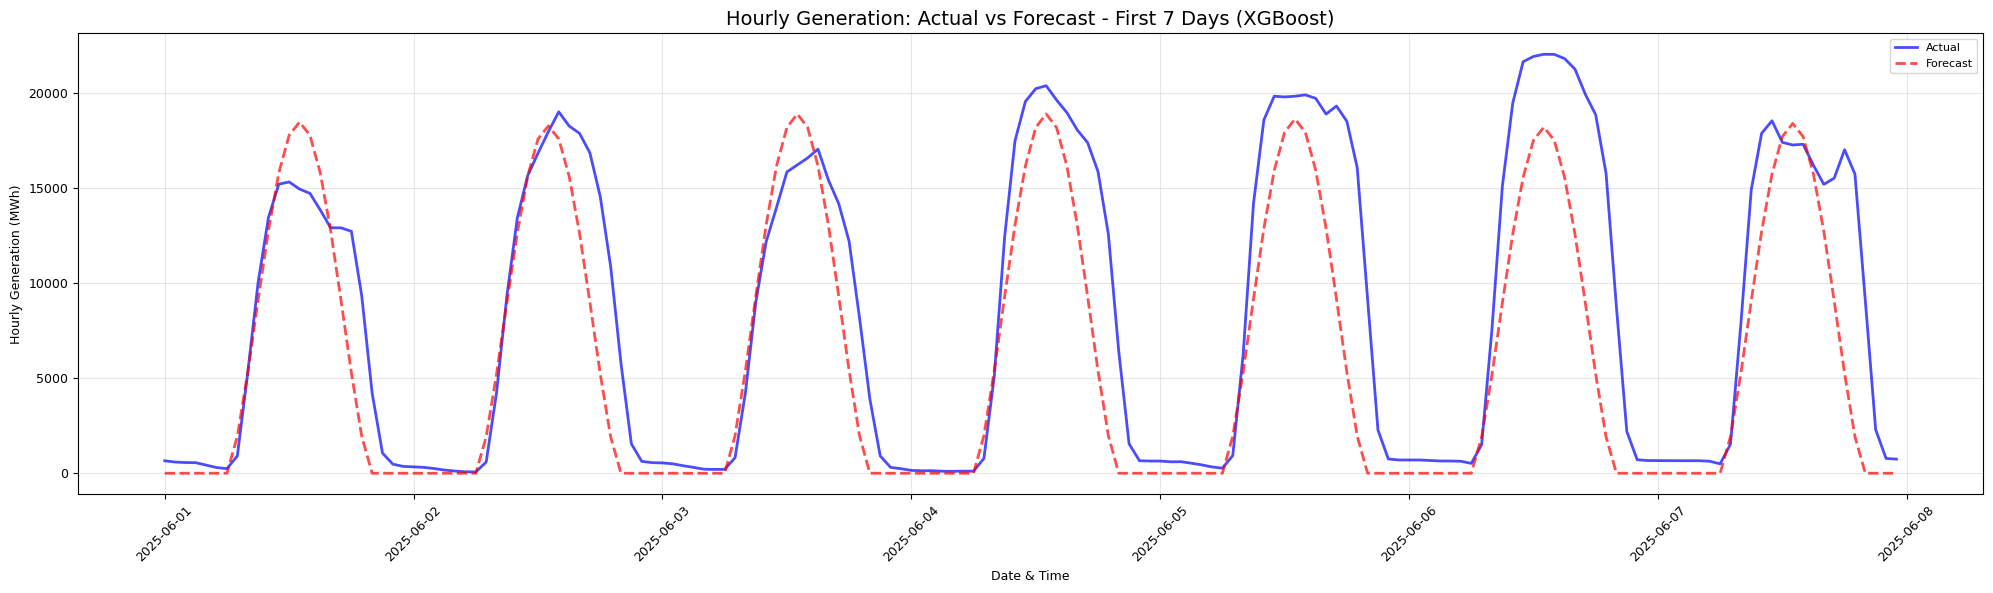


Hourly Error Statistics:
Mean Absolute Error: 3137.99 MWh/hour
Mean Percentage Error (daytime hours only): 84.40%
Max Error: 16218.97 MWh/hour
Std Dev of Error: 3638.92 MWh/hour

Error distribution by hour of day:
      Mean_Error  Std_Error  Max_Error
hour                                  
0         575.23     157.80     821.00
1         545.60     161.06     739.00
2         516.49     168.47     724.00
3         482.73     178.16     707.00
4         450.49     183.57     683.00
5         402.21     181.25     674.00
6         316.66     157.73     610.00
7        1231.38     371.16    1911.40
8        1517.29    1053.95    4211.67
9        3162.16    1927.97    6873.75
10       4241.94    2008.75    7533.23
11       3187.24    1920.29    6896.04
12       2440.21    1556.55    5819.83
13       2347.47    1499.55    6216.77
14       2706.47    1774.99    6922.83
15       3957.95    2142.13    8280.58
16       6202.80    2314.16   10346.98
17       9035.98    2376.51   13508.36
18   

In [21]:
# Cell 18 - Hourly performance visualization
# Plot hourly performance over time (sample: first 7 days)
sample_days = 7
sample_hours = sample_days * 24
comparison_sample = comparison.head(sample_hours)

plt.figure(figsize=(20, 6))
plt.plot(comparison_sample['datetime'], comparison_sample['generation'], 'b-', label='Actual', linewidth=2, alpha=0.7)
plt.plot(comparison_sample['datetime'], comparison_sample['yhat'], 'r--', label='Forecast', linewidth=2, alpha=0.7)
plt.title(f'Hourly Generation: Actual vs Forecast - First {sample_days} Days (XGBoost)', fontsize=14)
plt.xlabel('Date & Time')
plt.ylabel('Hourly Generation (MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate hourly error statistics
comparison['error'] = comparison['generation'] - comparison['yhat']
comparison['abs_error'] = np.abs(comparison['error'])

# Only calculate percentage error for significant generation hours
significant_gen_mask = comparison['generation'] >= 5  # MWh/hour
comparison['pct_error'] = np.where(
    significant_gen_mask,
    np.abs(comparison['error'] / comparison['generation']) * 100,
    np.nan
)

print("\nHourly Error Statistics:")
print(f"Mean Absolute Error: {comparison['abs_error'].mean():.2f} MWh/hour")
print(f"Mean Percentage Error (daytime hours only): {comparison['pct_error'].mean():.2f}%")
print(f"Max Error: {comparison['abs_error'].max():.2f} MWh/hour")
print(f"Std Dev of Error: {comparison['abs_error'].std():.2f} MWh/hour")

# Hourly pattern analysis
print("\nError distribution by hour of day:")
hourly_error_stats = comparison.groupby('hour')['abs_error'].agg(['mean', 'std', 'max']).round(2)
hourly_error_stats.columns = ['Mean_Error', 'Std_Error', 'Max_Error']
print(hourly_error_stats)

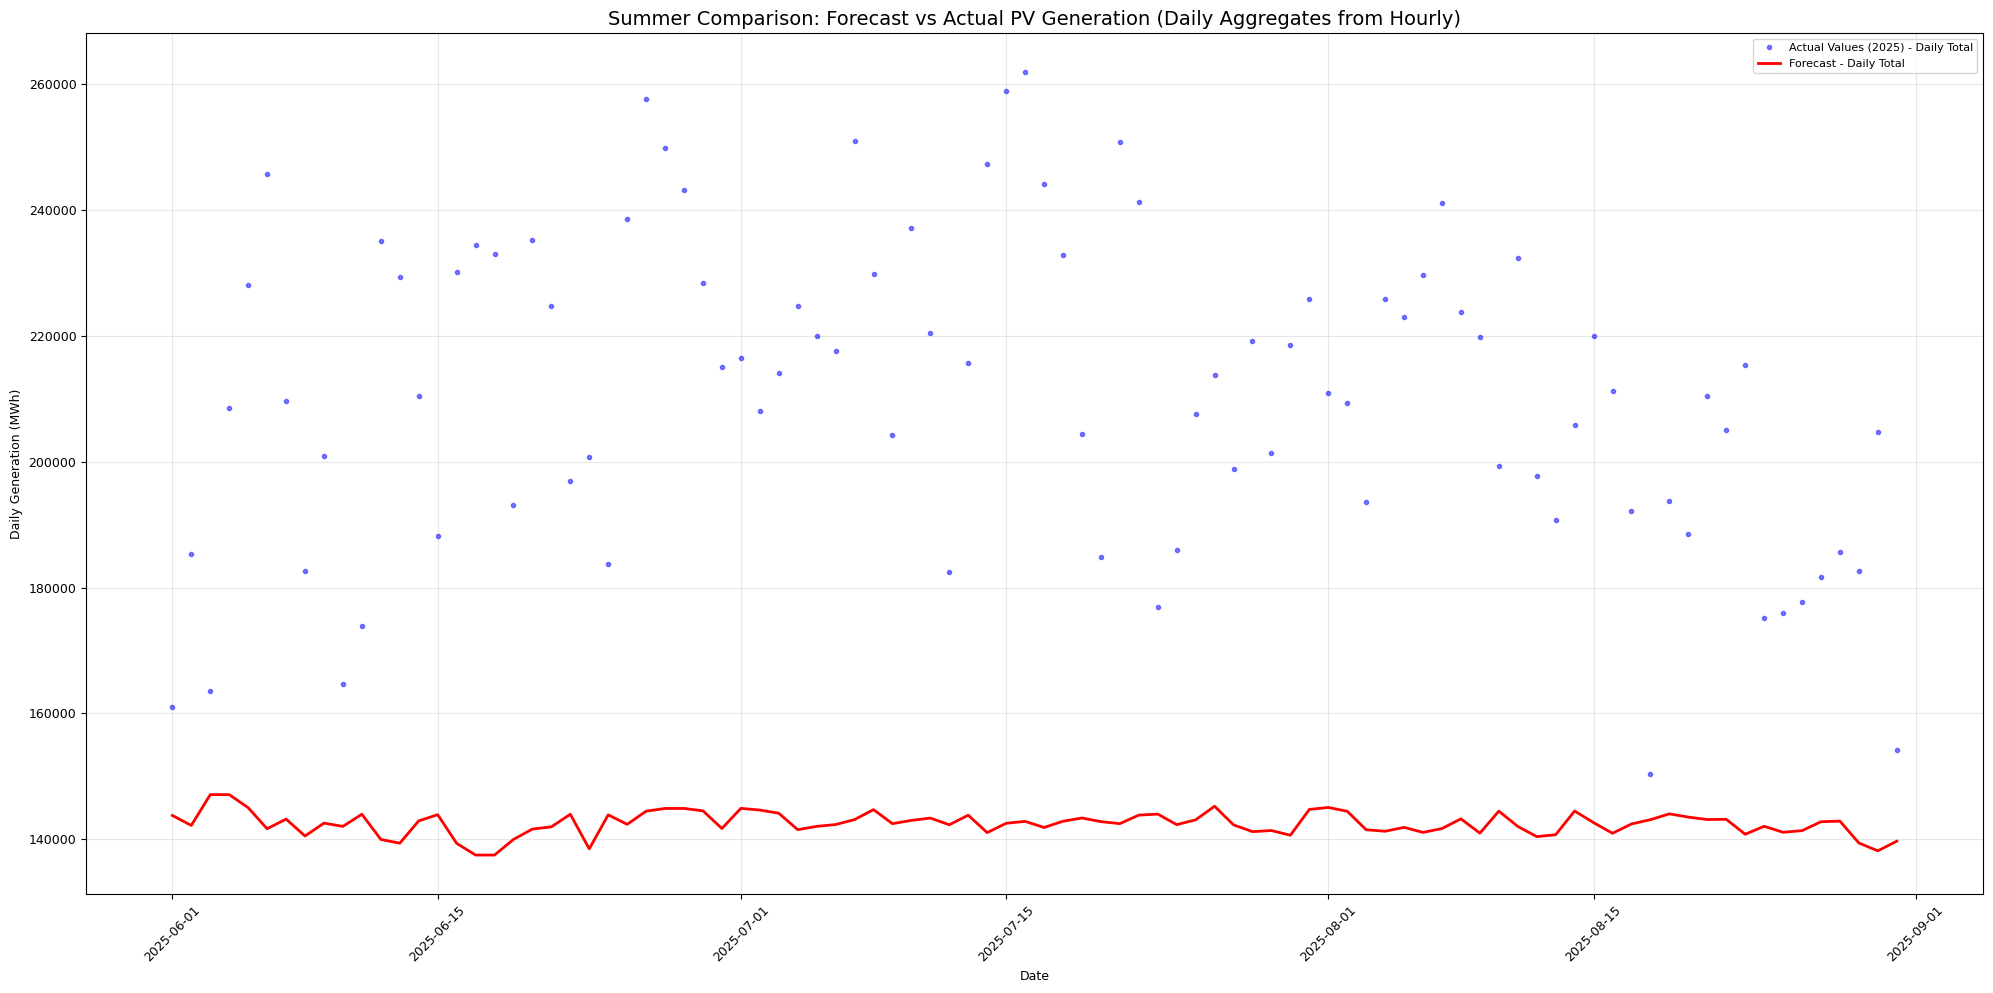


Monthly Performance Metrics (Daily Aggregates):
June 2025:
  Average Actual: 211727.33 MWh/day
  Average Forecast: 142413.47 MWh/day
  MAE: 69313.86 MWh/day
  RMSE: 74661.58 MWh/day
  MAPE: 31.51%
  R²: -6.5596
  nRMSE: 28.97%
---------------------------
July 2025:
  Average Actual: 219874.23 MWh/day
  Average Forecast: 142934.23 MWh/day
  MAE: 76939.99 MWh/day
  RMSE: 80042.70 MWh/day
  MAPE: 34.33%
  R²: -12.3074
  nRMSE: 30.57%
---------------------------
August 2025:
  Average Actual: 200896.57 MWh/day
  Average Forecast: 142082.79 MWh/day
  MAE: 58813.78 MWh/day
  RMSE: 62610.89 MWh/day
  MAPE: 28.41%
  R²: -7.4465
  nRMSE: 25.97%
---------------------------


Monthly Performance Metrics (HOURLY Data):
June 2025 (Daytime hours 6-20):
  Average Actual: 13753.30 MWh/hour
  Average Forecast: 9494.23 MWh/hour
  MAE: 4631.95 MWh/hour
  RMSE: 5969.22 MWh/hour
  MAPE: 45.06%
  R²: 0.2834
  nRMSE: 24.95%
---------------------------
July 2025 (Daytime hours 6-20):
  Average Actual: 14188.

In [22]:
# Cell 19 - Year-long comparison with hourly data (showing daily aggregates for clarity)
# Aggregate hourly data to daily for visualization
comparison['date'] = comparison['datetime'].dt.date
daily_agg = comparison.groupby('date').agg({
    'generation': 'sum',
    'yhat': 'sum'
}).reset_index()
daily_agg['date'] = pd.to_datetime(daily_agg['date'])

# Plot daily aggregates
plt.figure(figsize=(20, 10))
plt.plot(daily_agg['date'], daily_agg['generation'], 'b.', label='Actual Values (2025) - Daily Total', alpha=0.5, markersize=6)
plt.plot(daily_agg['date'], daily_agg['yhat'], 'r-', label='Forecast - Daily Total', linewidth=2)

plt.title("Summer Comparison: Forecast vs Actual PV Generation (Daily Aggregates from Hourly)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Daily Generation (MWh)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Add monthly statistics
from sklearn.metrics import r2_score

# Calculate R^2 and nRMSE for each month using DAILY aggregates
print("\nMonthly Performance Metrics (Daily Aggregates):")
print("===========================")

daily_agg['year_month'] = pd.to_datetime(daily_agg['date']).dt.to_period('M')
unique_months = daily_agg['year_month'].unique()

for month_period in unique_months:
    month_mask = daily_agg['year_month'] == month_period
    month_data = daily_agg[month_mask]
    
    if len(month_data) < 2:
        print(f"{month_period.strftime('%B %Y')}: No data available")
        print("---------------------------")
        continue
    
    actual = month_data['generation'].values
    predicted = month_data['yhat'].values
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    # Use daily installed capacity for normalization
    installed_cap_daily = actual.max()
    nrmse = (rmse / installed_cap_daily) * 100
    
    print(f"{month_period.strftime('%B %Y')}:")
    print(f"  Average Actual: {actual.mean():.2f} MWh/day")
    print(f"  Average Forecast: {predicted.mean():.2f} MWh/day")
    print(f"  MAE: {mae:.2f} MWh/day")
    print(f"  RMSE: {rmse:.2f} MWh/day")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²: {r2:.4f}")
    print(f"  nRMSE: {nrmse:.2f}%")
    print("---------------------------")

# Also show hourly statistics by month
print("\n\nMonthly Performance Metrics (HOURLY Data):")
print("===========================")

comparison['year_month'] = comparison['datetime'].dt.to_period('M')
unique_months_hourly = comparison['year_month'].unique()

for month_period in unique_months_hourly:
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    if len(month_data) < 2:
        continue
    
    # Daytime hours only
    daytime_mask = (month_data['hour'] >= 6) & (month_data['hour'] <= 20)
    month_daytime = month_data[daytime_mask]
    
    actual = month_daytime['generation'].values
    predicted = month_daytime['yhat'].values
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    
    # MAPE for significant hours
    sig_mask = actual >= 5
    if sig_mask.sum() > 0:
        mape = np.mean(np.abs((actual[sig_mask] - predicted[sig_mask]) / actual[sig_mask])) * 100
    else:
        mape = np.nan
    
    installed_cap_hourly = actual.max()
    nrmse = (rmse / installed_cap_hourly) * 100
    
    print(f"{month_period.strftime('%B %Y')} (Daytime hours 6-20):")
    print(f"  Average Actual: {actual.mean():.2f} MWh/hour")
    print(f"  Average Forecast: {predicted.mean():.2f} MWh/hour")
    print(f"  MAE: {mae:.2f} MWh/hour")
    print(f"  RMSE: {rmse:.2f} MWh/hour")
    if not np.isnan(mape):
        print(f"  MAPE: {mape:.2f}%")
    print(f"  R²: {r2:.4f}")
    print(f"  nRMSE: {nrmse:.2f}%")
    print("---------------------------")

In [23]:
# Cell 20 - Export HOURLY comparison data to CSV
# Export hourly comparison data to CSV
export_data = comparison.copy()

# Convert datetime to string for better CSV readability
export_data['datetime_str'] = export_data['datetime'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Select and rename columns for clarity
export_data = export_data[[
    'datetime_str',
    'generation', 
    'yhat',
    'hour'
]].rename(columns={
    'datetime_str': 'DateTime',
    'generation': 'Actual_Generation_MWh',
    'yhat': 'Forecast_Generation_MWh',
    'hour': 'Hour'
})

# Add error columns
export_data['Absolute_Error_MWh'] = abs(export_data['Actual_Generation_MWh'] - export_data['Forecast_Generation_MWh'])

# Calculate percentage error only for significant generation hours
export_data['Percentage_Error'] = np.where(
    export_data['Actual_Generation_MWh'] >= 5,
    (export_data['Absolute_Error_MWh'] / export_data['Actual_Generation_MWh']) * 100,
    np.nan
)

# Export to CSV
output_path = 'pv_forecast_summer_comparison_2025_xgboost_hourly.csv'
export_data.to_csv(output_path, index=False)
print(f"Summer HOURLY comparison data exported to: {output_path}")
print(f"Total records exported: {len(export_data)} hours (Jun-Aug 2025)")
print("\nFirst 24 hours of exported data:")
print(export_data.head(24).to_string())

Summer HOURLY comparison data exported to: pv_forecast_summer_comparison_2025_xgboost_hourly.csv
Total records exported: 2208 hours (Jun-Aug 2025)

First 24 hours of exported data:
               DateTime  Actual_Generation_MWh  Forecast_Generation_MWh  Hour  Absolute_Error_MWh  Percentage_Error
0   2025-06-01 00:00:00                  654.0             0.000000e+00     0          654.000000        100.000000
1   2025-06-01 01:00:00                  588.0             0.000000e+00     1          588.000000        100.000000
2   2025-06-01 02:00:00                  563.0             0.000000e+00     2          563.000000        100.000000
3   2025-06-01 03:00:00                  554.0             0.000000e+00     3          554.000000        100.000000
4   2025-06-01 04:00:00                  424.0             0.000000e+00     4          424.000000        100.000000
5   2025-06-01 05:00:00                  298.0             0.000000e+00     5          298.000000        100.000000
6   202

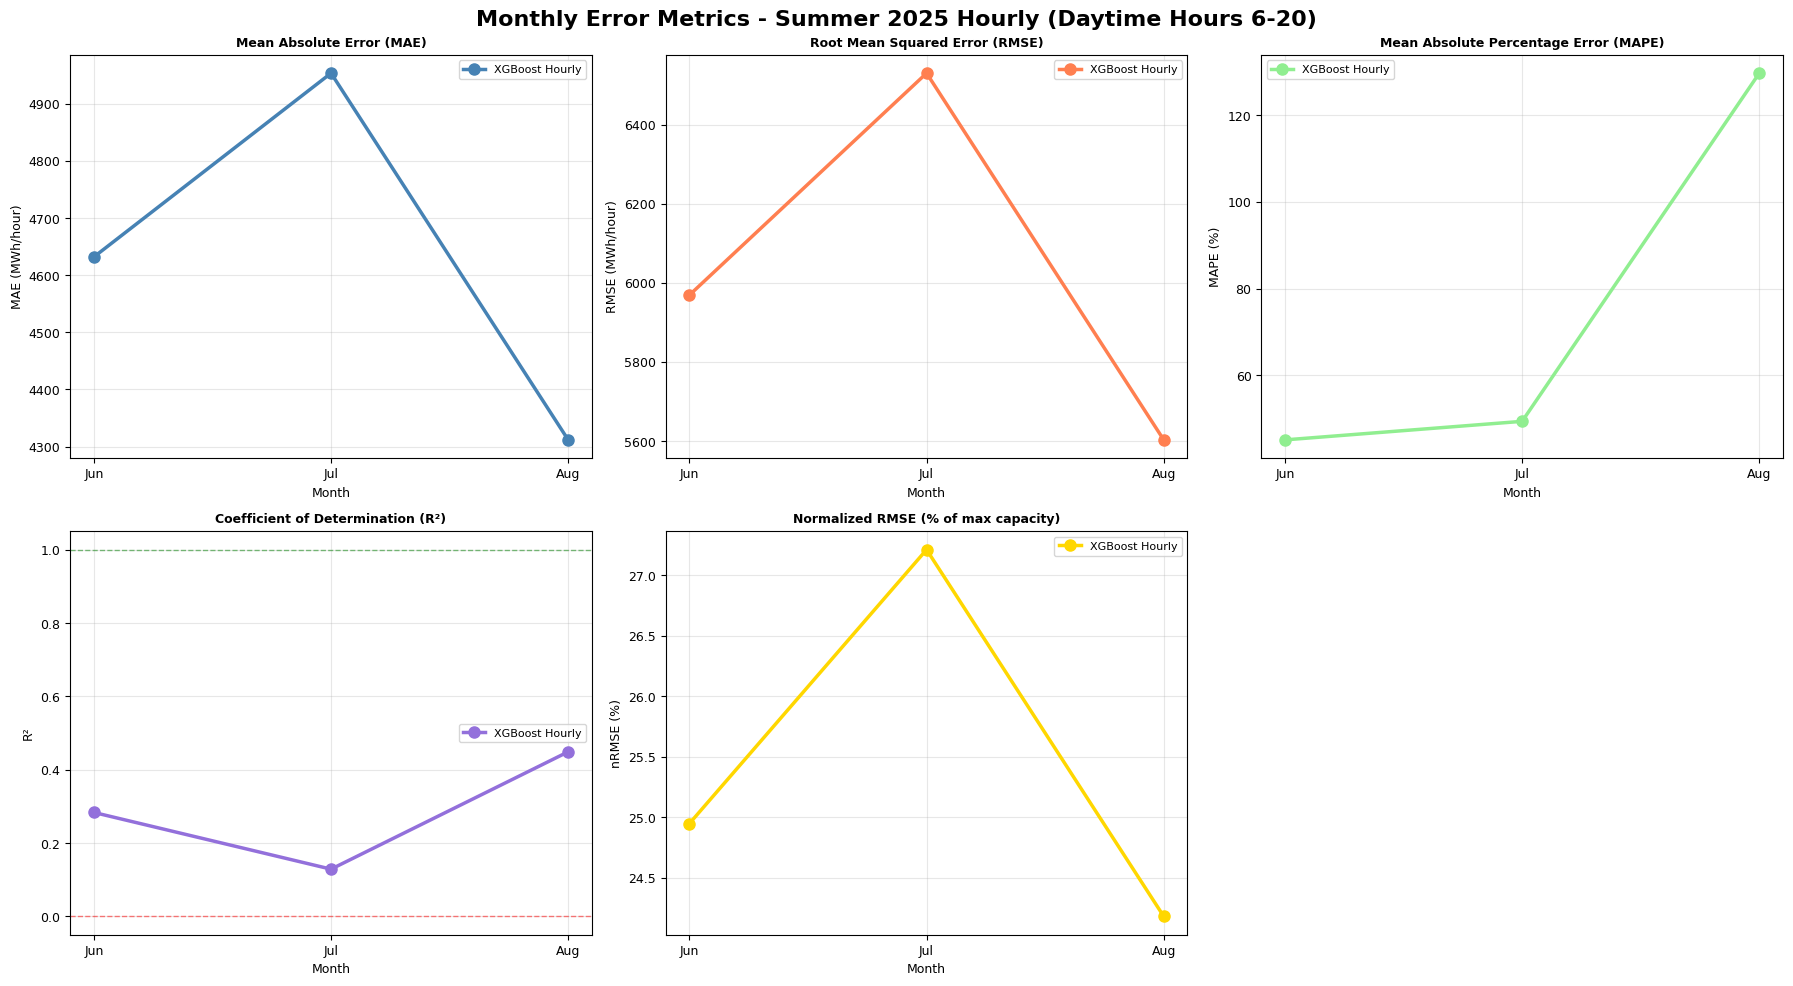


Overall Summer Statistics (Hourly - Daytime Hours):
  Best R² Month: Aug (0.4488)
  Worst R² Month: Jul (0.1288)
  Lowest MAE Month: Aug (4311.80 MWh/hour)
  Highest MAE Month: Jul (4953.59 MWh/hour)


In [24]:
# Cell 21 - Monthly error metrics visualization for HOURLY data
from sklearn.metrics import r2_score

# Calculate metrics for each month using HOURLY data (daytime hours only)
monthly_metrics_data = []

comparison['year_month'] = comparison['datetime'].dt.to_period('M')
unique_months = sorted(comparison['year_month'].unique())

for month_period in unique_months:
    month_mask = comparison['year_month'] == month_period
    month_data = comparison[month_mask]
    
    if len(month_data) < 2:
        continue
    
    # Filter for daytime hours (6 AM to 8 PM)
    daytime_mask = (month_data['hour'] >= 6) & (month_data['hour'] <= 20)
    month_daytime = month_data[daytime_mask]
    
    if len(month_daytime) < 2:
        continue
    
    actual = month_daytime['generation'].values
    predicted = month_daytime['yhat'].values
    
    # Calculate all metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # MAPE (excluding very low generation hours)
    sig_mask = actual >= 5
    if sig_mask.sum() > 0:
        mape = np.mean(np.abs((actual[sig_mask] - predicted[sig_mask]) / actual[sig_mask])) * 100
    else:
        mape = np.nan
    
    # R²
    r2 = r2_score(actual, predicted)
    
    # nRMSE (normalized by max hourly capacity)
    installed_cap = actual.max()
    nrmse = (rmse / installed_cap) * 100
    
    monthly_metrics_data.append({
        'Month': month_period.strftime('%b'),
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2,
        'nRMSE': nrmse
    })

# Create DataFrame for easier plotting
metrics_df = pd.DataFrame(monthly_metrics_data)

# Create subplots for each metric (2x3 layout)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Monthly Error Metrics - Summer 2025 Hourly (Daytime Hours 6-20)', fontsize=16, fontweight='bold')

# Plot 1: MAE
ax1 = axes[0, 0]
ax1.plot(metrics_df['Month'], metrics_df['MAE'], marker='o', color='steelblue', 
         linewidth=2.5, markersize=8, label='XGBoost Hourly')
ax1.set_title('Mean Absolute Error (MAE)', fontweight='bold')
ax1.set_ylabel('MAE (MWh/hour)')
ax1.set_xlabel('Month')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# Plot 2: RMSE
ax2 = axes[0, 1]
ax2.plot(metrics_df['Month'], metrics_df['RMSE'], marker='o', color='coral', 
         linewidth=2.5, markersize=8, label='XGBoost Hourly')
ax2.set_title('Root Mean Squared Error (RMSE)', fontweight='bold')
ax2.set_ylabel('RMSE (MWh/hour)')
ax2.set_xlabel('Month')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Plot 3: MAPE
ax3 = axes[0, 2]
ax3.plot(metrics_df['Month'], metrics_df['MAPE'], marker='o', color='lightgreen', 
         linewidth=2.5, markersize=8, label='XGBoost Hourly')
ax3.set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
ax3.set_ylabel('MAPE (%)')
ax3.set_xlabel('Month')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='best')

# Plot 4: R²
ax4 = axes[1, 0]
ax4.plot(metrics_df['Month'], metrics_df['R²'], marker='o', color='mediumpurple', 
         linewidth=2.5, markersize=8, label='XGBoost Hourly')
ax4.set_title('Coefficient of Determination (R²)', fontweight='bold')
ax4.set_ylabel('R²')
ax4.set_xlabel('Month')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax4.axhline(y=1, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax4.grid(True, alpha=0.3)
ax4.legend(loc='best')

# Plot 5: nRMSE
ax5 = axes[1, 1]
ax5.plot(metrics_df['Month'], metrics_df['nRMSE'], marker='o', color='gold', 
         linewidth=2.5, markersize=8, label='XGBoost Hourly')
ax5.set_title('Normalized RMSE (% of max capacity)', fontweight='bold')
ax5.set_ylabel('nRMSE (%)')
ax5.set_xlabel('Month')
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best')

# Hide the unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print(f"\nOverall Summer Statistics (Hourly - Daytime Hours):")
print(f"  Best R² Month: {metrics_df.loc[metrics_df['R²'].idxmax(), 'Month']} ({metrics_df['R²'].max():.4f})")
print(f"  Worst R² Month: {metrics_df.loc[metrics_df['R²'].idxmin(), 'Month']} ({metrics_df['R²'].min():.4f})")
print(f"  Lowest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Month']} ({metrics_df['MAE'].min():.2f} MWh/hour)")
print(f"  Highest MAE Month: {metrics_df.loc[metrics_df['MAE'].idxmax(), 'Month']} ({metrics_df['MAE'].max():.2f} MWh/hour)")

In [25]:
metrics_df.to_csv('xg_metrics_6-8_disagg.csv', index=False)
metrics_df

,Month,MAE,RMSE,MAPE,R²,nRMSE
0,Jun,4631.953239,5969.219230,45.062946,0.283410,24.949715
1,Jul,4953.590904,6530.555236,49.346218,0.128788,27.211781
2,Aug,4311.800127,5602.948040,129.728589,0.448806,24.182952


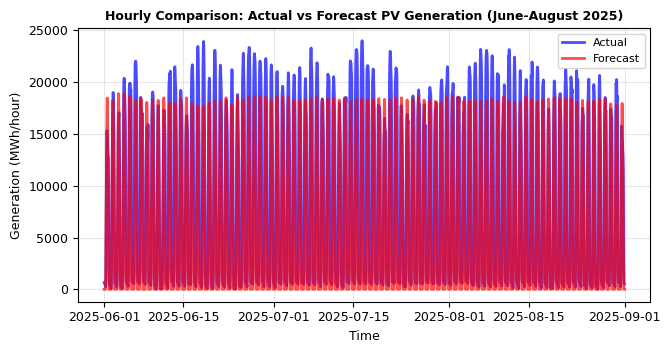

Hourly comparison period: 2025-06-01 00:00:00 to 2025-08-31 23:00:00
Total hours plotted: 2208


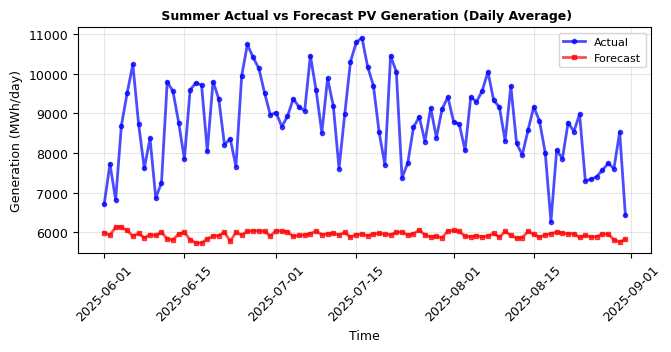


Daily comparison period: 2025-06-01 00:00:00 to 2025-08-31 00:00:00
Total days plotted: 92

Daily statistics:
  Actual - Mean: 8784.29 MWh/day, Std: 1043.29
  Forecast - Mean: 5936.56 MWh/day, Std: 77.79


In [32]:
# 1. HOURLY comparison: Forecasted vs Actual Generation over time
fig, ax = plt.subplots(figsize=(6.8, 3.6))

# Plot actual and forecast hourly data
ax.plot(comparison['datetime'], comparison['generation'], 
        label='Actual', color='blue', alpha=0.7)#, linewidth=1.5)
ax.plot(comparison['datetime'], comparison['yhat'], 
        label='Forecast', color='red', alpha=0.7)#, linewidth=1.5)

ax.set_title('Hourly Comparison: Actual vs Forecast PV Generation (June-August 2025)', fontweight='bold', 
                )#fontsize=14)
ax.set_xlabel('Time')#, fontsize=12)
ax.set_ylabel('Generation (MWh/hour)')#, fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Hourly comparison period: {comparison['datetime'].min()} to {comparison['datetime'].max()}")
print(f"Total hours plotted: {len(comparison)}")


# 2. DAILY comparison: Forecasted vs Actual Generation over time
# Aggregate hourly data to daily totals
daily_comparison = comparison.copy()
daily_comparison['date'] = daily_comparison['datetime'].dt.date

daily_agg = daily_comparison.groupby('date').agg({
    'generation': 'mean',  # Actual daily total
    'yhat': 'mean'  # Forecast daily total
}).reset_index()

daily_agg['date'] = pd.to_datetime(daily_agg['date'])

fig, ax = plt.subplots(figsize=(6.8, 3.6))

# Plot actual and forecast daily data
ax.plot(daily_agg['date'], daily_agg['generation'], 
        label='Actual', color='blue', marker='o', alpha=0.7)#, linewidth=2, markersize=4)
ax.plot(daily_agg['date'], daily_agg['yhat'], 
        label='Forecast', color='red', marker='s', alpha=0.7)#, linewidth=2, markersize=4)

ax.set_title(' Summer Actual vs Forecast PV Generation (Daily Average)', fontweight='bold', 
                )#fontsize=14)
ax.set_xlabel('Time')#, fontsize=12)
ax.set_ylabel('Generation (MWh/day)')#, fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/xg_6-8_comp_disagg.pdf')
plt.show()

print(f"\nDaily comparison period: {daily_agg['date'].min()} to {daily_agg['date'].max()}")
print(f"Total days plotted: {len(daily_agg)}")
print(f"\nDaily statistics:")
print(f"  Actual - Mean: {daily_agg['generation'].mean():.2f} MWh/day, Std: {daily_agg['generation'].std():.2f}")
print(f"  Forecast - Mean: {daily_agg['yhat'].mean():.2f} MWh/day, Std: {daily_agg['yhat'].std():.2f}")